# Data collections

Sentinel Hub services enable access to a large number of satellite data collections. Specifications about data collections are available in the official [Sentinel Hub service documentation](https://docs.sentinel-hub.com/api/latest/data/). In this tutorial, we will show how to obtain data from a desired data collection with `sentinelhub-py`.


## Use an existing data collection definition

A data collection is in the package defined with a `DataCollection` class.

In [1]:
from sentinelhub import DataCollection

The class contains a collection of most commonly used data collection definitions:

In [2]:
for collection in DataCollection.get_available_collections():
    print(collection)

DataCollection.SENTINEL2_L1C
DataCollection.SENTINEL2_L2A
DataCollection.SENTINEL1
DataCollection.SENTINEL1_IW
DataCollection.SENTINEL1_IW_ASC
DataCollection.SENTINEL1_IW_DES
DataCollection.SENTINEL1_EW
DataCollection.SENTINEL1_EW_ASC
DataCollection.SENTINEL1_EW_DES
DataCollection.SENTINEL1_EW_SH
DataCollection.SENTINEL1_EW_SH_ASC
DataCollection.SENTINEL1_EW_SH_DES
DataCollection.DEM
DataCollection.DEM_MAPZEN
DataCollection.DEM_COPERNICUS_30
DataCollection.DEM_COPERNICUS_90
DataCollection.MODIS
DataCollection.LANDSAT_MSS_L1
DataCollection.LANDSAT_TM_L1
DataCollection.LANDSAT_TM_L2
DataCollection.LANDSAT_ETM_L1
DataCollection.LANDSAT_ETM_L2
DataCollection.LANDSAT_OT_L1
DataCollection.LANDSAT_OT_L2
DataCollection.SENTINEL5P
DataCollection.SENTINEL3_OLCI
DataCollection.SENTINEL3_SLSTR


Each of them is defined with a number of parameters:

In [3]:
DataCollection.SENTINEL2_L2A

<DataCollection.SENTINEL2_L2A: DataCollectionDefinition(
  api_id: sentinel-2-l2a
  catalog_id: sentinel-2-l2a
  wfs_id: DSS2
  service_url: https://services.sentinel-hub.com
  collection_type: Sentinel-2
  sensor_type: MSI
  processing_level: L2A
  bands: ('B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12')
  is_timeless: False
  has_cloud_coverage: True
)>

Such a data collection definition is used as a parameter for a Process API request:

In [4]:
from sentinelhub import CRS, BBox, MimeType, SentinelHubRequest, SHConfig

# Write your credentials here if you haven't already put them into config.json
CLIENT_ID = ""
CLIENT_SECRET = ""

config = SHConfig()
if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET


# Columbia Glacier, Alaska
glacier_bbox = BBox([-147.8, 60.96, -146.5, 61.38], crs=CRS.WGS84)
glacier_size = (700, 466)
time_interval = "2020-07-15", "2020-07-16"

evalscript_true_color = """
//VERSION=3

function setup() {
    return {
        input: [{
            bands: ["B02", "B03", "B04"]
        }],
        output: {
            bands: 3
        }
    };
}

function evaluatePixel(sample) {
    return [sample.B04, sample.B03, sample.B02];
}
"""

request = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=time_interval,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=glacier_bbox,
    size=glacier_size,
    config=config,
)

image = request.get_data()[0]

Let's plot the image:

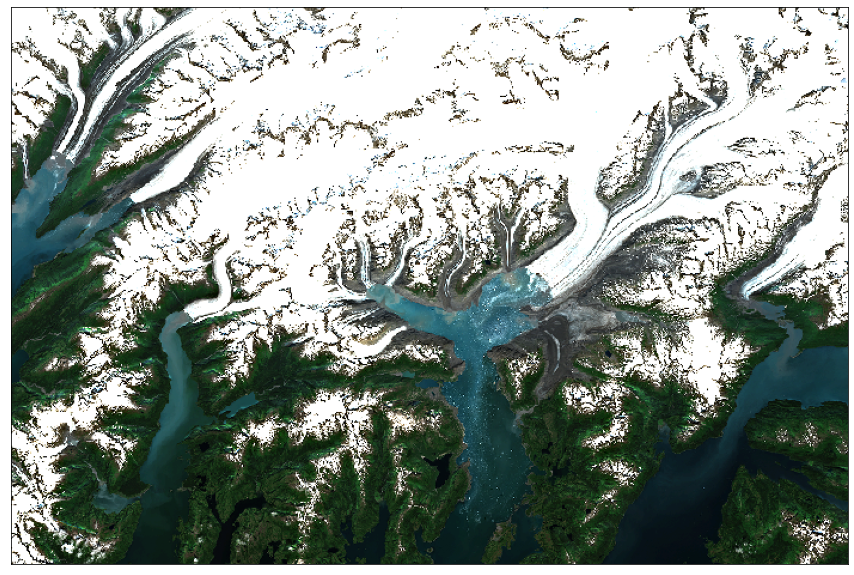

In [5]:
%matplotlib inline

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

Next, we'll switch data collection to Sentinel-1, which is a SAR data collection. We'll choose only data with IW polarization and limit ourselves to ascending orbits.

In [6]:
DataCollection.SENTINEL1_IW_ASC

<DataCollection.SENTINEL1_IW_ASC: DataCollectionDefinition(
  api_id: sentinel-1-grd
  catalog_id: sentinel-1-grd
  wfs_id: DSS3
  service_url: https://services.sentinel-hub.com
  collection_type: Sentinel-1
  sensor_type: C-SAR
  processing_level: GRD
  swath_mode: IW
  polarization: DV
  resolution: HIGH
  orbit_direction: ASCENDING
  bands: ('VV', 'VH')
  is_timeless: False
  has_cloud_coverage: False
)>

This time we'll use a simplified structure of an evalscript:

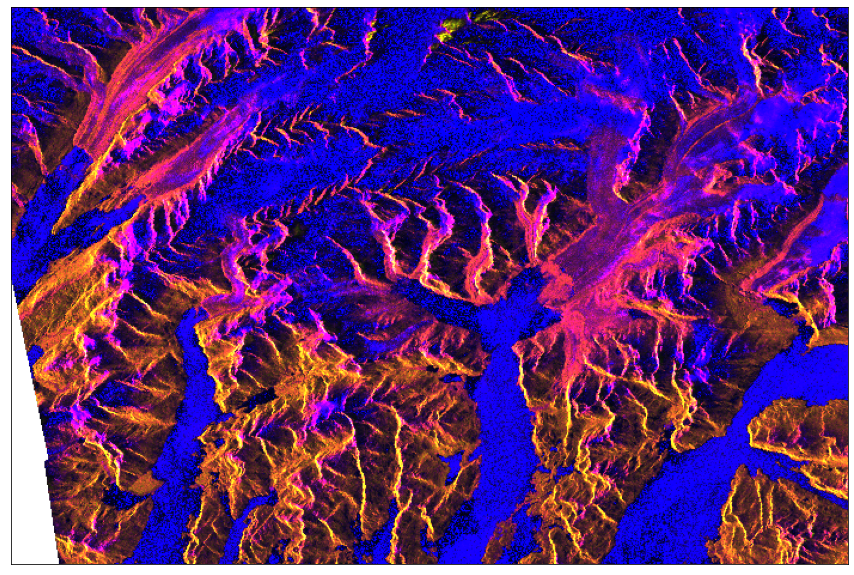

In [7]:
evalscript = """
//VERSION=3

return [VV, 2 * VH, VV / VH / 100.0, dataMask]
"""

time_interval = "2020-07-06", "2020-07-07"

request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL1_IW_ASC,
            time_interval=time_interval,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=glacier_bbox,
    size=glacier_size,
    config=config,
)

image = request.get_data()[0]

plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

Let's also check a Sentinel-3 OLCI data collection:

In [8]:
DataCollection.SENTINEL3_OLCI

<DataCollection.SENTINEL3_OLCI: DataCollectionDefinition(
  api_id: sentinel-3-olci
  catalog_id: sentinel-3-olci
  wfs_id: DSS8
  service_url: https://creodias.sentinel-hub.com
  collection_type: Sentinel-3
  sensor_type: OLCI
  processing_level: L1B
  bands: ('B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21')
  is_timeless: False
  has_cloud_coverage: False
)>

Notice that its definition contains a different `service_url` parameter. Its value is used to override a default `sh_base_url` defined in `config` object.

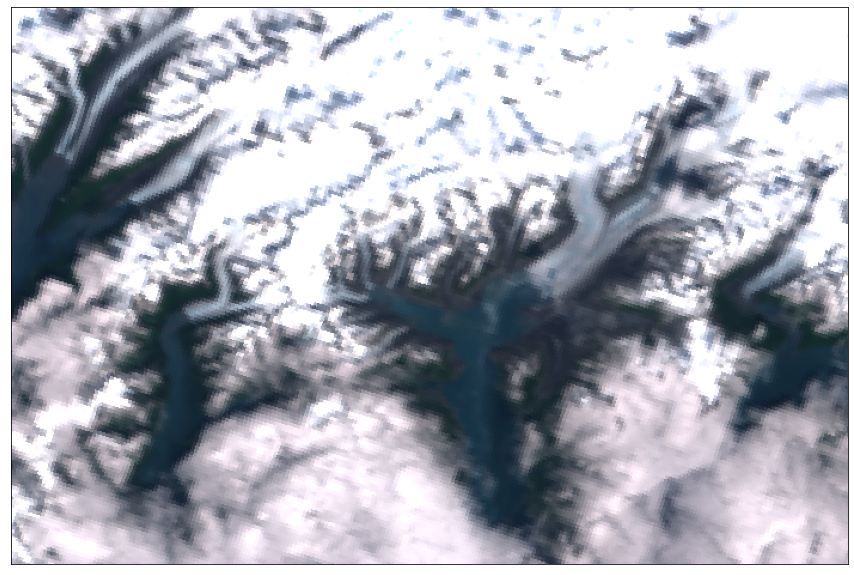

In [9]:
evalscript = """
//VERSION=3

return [B08, B06, B04]
"""

time_interval = "2020-07-06", "2020-07-07"

request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL3_OLCI,
            time_interval=time_interval,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=glacier_bbox,
    size=glacier_size,
    config=config,
)

image = request.get_data()[0]

plot_image(image, factor=1.5 / 255, clip_range=(0, 1))

## Define a new data collection

To support a growing number of new data collections it is possible to define a new data collection. A data collection definition supports many parameters, but it is only required to fill those parameters that will actually be required in the code.

In [10]:
DataCollection.define(
    name="CUSTOM_SENTINEL1",
    api_id="S1GRD",
    catalog_id="sentinel-1-grd",
    wfs_id="DSS3",
    service_url="https://services.sentinel-hub.com",
    collection_type="Sentinel-1",
    sensor_type="C-SAR",
    processing_level="GRD",
    swath_mode="IW",
    polarization="SV",
    resolution="HIGH",
    orbit_direction="ASCENDING",
    timeliness="NRT10m",
    bands=("VV",),
    is_timeless=False,
)

<DataCollection.CUSTOM_SENTINEL1: DataCollectionDefinition(
  api_id: S1GRD
  catalog_id: sentinel-1-grd
  wfs_id: DSS3
  service_url: https://services.sentinel-hub.com
  collection_type: Sentinel-1
  sensor_type: C-SAR
  processing_level: GRD
  swath_mode: IW
  polarization: SV
  resolution: HIGH
  orbit_direction: ASCENDING
  timeliness: NRT10m
  bands: ('VV',)
  is_timeless: False
  has_cloud_coverage: False
)>

The most common examples of user-defined data collections are ["bring your own data" (BYOC) data collections](https://docs.sentinel-hub.com/api/latest/data/byoc/), where users can bring their own data and access it with Sentinel Hub service. To be able to do that you will need to prepare a few things. Roughly speaking, these are the following (find all details [here](https://docs.sentinel-hub.com/api/latest/#/API/byoc)):

- Convert your data to Cloud Optimized GeoTiff (COG) format. Store it in an AWS S3 bucket and allow SH to access it.
- Create a collection in SH, which points to the S3 bucket. Within the collection, ingest the tiles from the bucket.

To demonstrate this, we have prepared an example collection with a Slovenian land-cover reference map. It is available with the collection id at `7453e962-0ee5-4f74-8227-89759fbe9ba9`.

Now we can define a new BYOC data collection either with `DataCollection.define` method or with a more convenient `DataCollection.define_byoc` method:

In [11]:
collection_id = "7453e962-0ee5-4f74-8227-89759fbe9ba9"

byoc = DataCollection.define_byoc(collection_id, name="SLOVENIA_LAND_COVER", is_timeless=True)

byoc

<DataCollection.SLOVENIA_LAND_COVER: DataCollectionDefinition(
  api_id: byoc-7453e962-0ee5-4f74-8227-89759fbe9ba9
  catalog_id: byoc-7453e962-0ee5-4f74-8227-89759fbe9ba9
  wfs_id: byoc-7453e962-0ee5-4f74-8227-89759fbe9ba9
  collection_type: BYOC
  collection_id: 7453e962-0ee5-4f74-8227-89759fbe9ba9
  is_timeless: True
  has_cloud_coverage: False
)>

Let's load data for defined BYOC data collection:

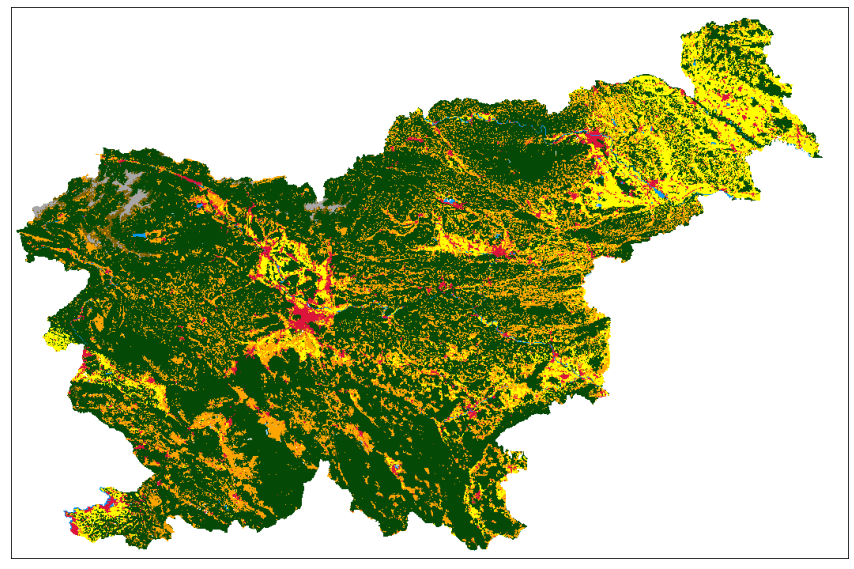

In [12]:
from sentinelhub import bbox_to_dimensions

slovenia_bbox = BBox([13.353882, 45.402307, 16.644287, 46.908998], crs=CRS.WGS84)
slovenia_size = bbox_to_dimensions(slovenia_bbox, resolution=240)

evalscript_byoc = """
//VERSION=3
function setup() {
  return {
    input: ["lulc_reference"],
    output: { bands: 3 }
  };
}

var colorDict = {
  0: [255/255, 255/255, 255/255],
  1: [255/255, 255/255, 0/255],
  2: [5/255, 73/255, 7/255],
  3: [255/255, 165/255, 0/255],
  4: [128/255, 96/255, 0/255],
  5: [6/255, 154/255, 243/255],
  6: [149/255, 208/255, 252/255],
  7: [150/255, 123/255, 182/255],
  8: [220/255, 20/255, 60/255],
  9: [166/255, 166/255, 166/255],
  10: [0/255, 0/255, 0/255]
}

function evaluatePixel(sample) {
  return colorDict[sample.lulc_reference];
}
"""

byoc_request = SentinelHubRequest(
    evalscript=evalscript_byoc,
    input_data=[SentinelHubRequest.input_data(data_collection=byoc)],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=slovenia_bbox,
    size=slovenia_size,
    config=config,
)

byoc_data = byoc_request.get_data()
plot_image(byoc_data[0], factor=1 / 255)

Another option is to take an existing data collection and create a new data collection from it. The following will create a data collection with a different `service_url` parameter. Instead of collecting data from a default Sentinel Hub deployment it will collect data from [MUNDI](https://mundiwebservices.com/) deployment.

In [13]:
s2_l2a_mundi = DataCollection.define_from(
    DataCollection.SENTINEL2_L2A, "SENTINEL2_L2A_MUNDI", service_url="https://shservices.mundiwebservices.com"
)

s2_l2a_mundi

<DataCollection.SENTINEL2_L2A_MUNDI: DataCollectionDefinition(
  api_id: sentinel-2-l2a
  catalog_id: sentinel-2-l2a
  wfs_id: DSS2
  service_url: https://shservices.mundiwebservices.com
  collection_type: Sentinel-2
  sensor_type: MSI
  processing_level: L2A
  bands: ('B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12')
  is_timeless: False
  has_cloud_coverage: True
)>

Request URL: https://shservices.mundiwebservices.com/api/v1/process


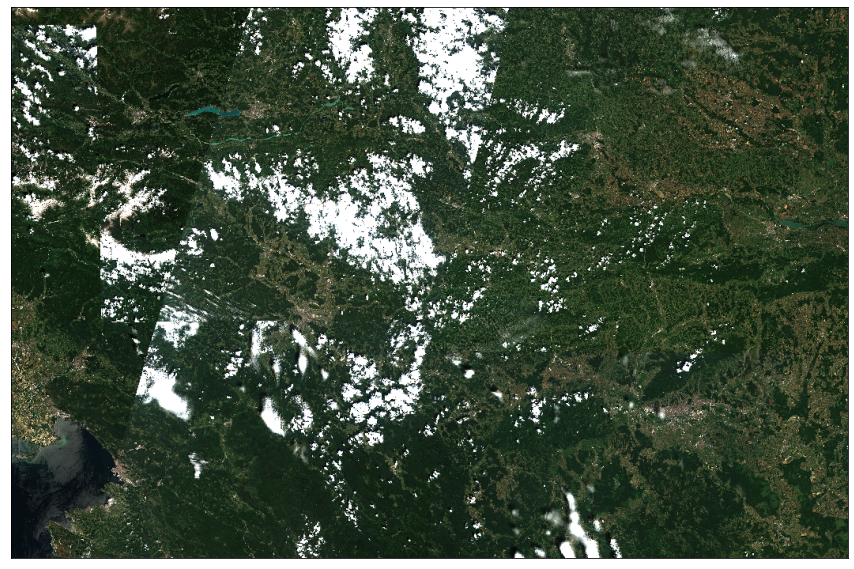

In [14]:
from sentinelhub import MosaickingOrder

time_interval = "2020-06-01", "2020-07-01"

evalscript = """
//VERSION=3

function setup() {
    return {
        input: [{
            bands: ["B02", "B03", "B04"]
        }],
        output: {
            bands: 3
        }
    };
}

function evaluatePixel(sample) {
    return [sample.B04, sample.B03, sample.B02];
}
"""

request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=s2_l2a_mundi, time_interval=time_interval, mosaicking_order=MosaickingOrder.LEAST_CC
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=slovenia_bbox,
    size=slovenia_size,
    config=config,
)

image = request.get_data()[0]

print("Request URL:", request.download_list[0].url)

plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

## Data fusion

An advanced way of using data collections is to define an evalscript that joins together data from different collections and downloads only the results. This is called data fusion and is described in detail in [Sentinel Hub documentation](https://docs.sentinel-hub.com/api/latest/data/data-fusion/).

In this example we will do a data fusion that uses Sentinel-2 data to pan-sharpen Landsat-8 data.

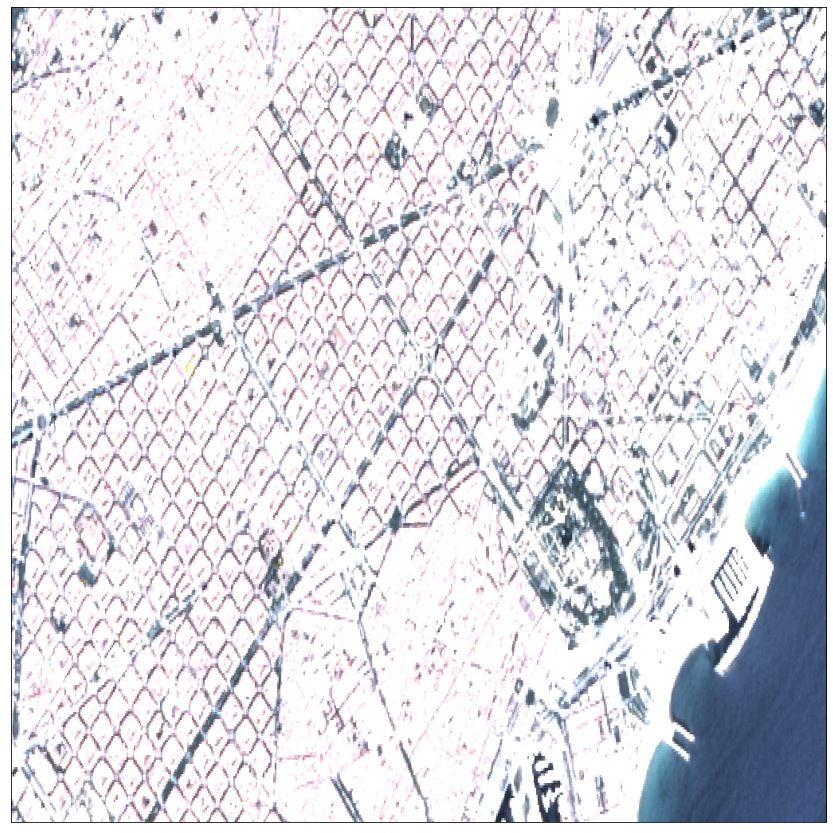

In [15]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
        datasource: "ls8",
        bands: ["B02", "B03", "B04", "B05", "B08"]
      },
      {
        datasource: "l2a",
        bands: ["B02", "B03", "B04", "B08", "B11"]
      }
    ],
    output: [{
      bands: 3
    }]
  }
}
let minVal = 0.0
let maxVal = 0.4
let viz = new DefaultVisualizer(minVal, maxVal)

function evaluatePixel(samples, inputData, inputMetadata, customData, outputMetadata) {
  var sample = samples.ls8[0]
  var sample2 = samples.l2a[0]
  // Use weighted arithmetic average of S2.B02 - S2.B04 for pan-sharpening
  let sudoPanW3 = (sample.B04 + sample.B03 + sample.B02) / 3
  let s2PanR3 = (sample2.B04 + sample2.B03 + sample2.B02) / 3
  let s2ratioWR3 = s2PanR3 / sudoPanW3
  let val = [sample.B04 * s2ratioWR3, sample.B03 * s2ratioWR3, sample.B02 * s2ratioWR3]
  return viz.processList(val)
}
"""

request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.LANDSAT_OT_L1,
            identifier="ls8",  # has to match Landsat input datasource id in evalscript
            time_interval=("2020-05-21", "2020-05-23"),
        ),
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            identifier="l2a",  # has to match Sentinel input datasource id in evalscript
            time_interval=("2020-05-21", "2020-05-23"),
        ),
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=BBox((2.142, 41.378, 2.208, 41.408), CRS.WGS84),
    size=(1024, 1024),
    config=config,
)

image = request.get_data()[0]

plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

Notice that the main difference in defining a `SentinelHubRequest` object is that for data fusion we had to define `identifier` parameters. They are used to match request collections with collections defined in the evalscript.

In this case, `DataCollection` objects for Sentinel-2 and Landsat-8 were defined with different service URLs. Because of that, the base URL from a configuration object was taken to decide, to which service the request should be sent.

In [16]:
print("Default Landsat-8 collection base URL:", DataCollection.LANDSAT_OT_L1.service_url)
print("Default Sentinel-2 collection base URL:", DataCollection.SENTINEL2_L2A.service_url)
print("Base URL from config breaks the tie:", config.sh_base_url)

print("Request URL:", request.download_list[0].url)

Default Landsat-8 collection base URL: https://services-uswest2.sentinel-hub.com
Default Sentinel-2 collection base URL: https://services.sentinel-hub.com
Base URL from config breaks the tie: https://services.sentinel-hub.com
Request URL: https://services.sentinel-hub.com/api/v1/process
